# Neurons & Behavior

In this notebook, we'll look at behavior in the Allen Brain Observatory two-photon imaging dataset. Specifically, we'll see if we can use the activity of neurons to predict the animal's running speed.

In [1]:
# Typical toolboxes
import numpy as np
import pandas as pd
import scipy as sp

# Plotting setup
%config InlineBackend.figure_format = 'retina' # Improve the resolution of our plots!
%matplotlib inline
import matplotlib.pyplot as plt

## Step I. Get raw fluorescence & running traces

This dataset uses **2-photon calcium imaging** to measure neural activity in mice while they're running on a wheel and viewing visual stimuli. We don't have access to the animal's performance on the task, but we can still use the animal's movement on the wheel (a very rich measure of arousal, actually!) as an interesting behavioral output.

First, let's get some data.

In [25]:
# Allen specific toolboxes
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

boc = BrainObservatoryCache(manifest_file='/datasets/allen-brain-observatory/visual-coding-2p/manifest.json')

# Get the drifting gratings experiments for a specific cell ID
cell_id = 662074297 #541513979
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])

# Let's just look at the first session
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)



In [28]:
exps

[{'id': 605859367,
  'imaging_depth': 175,
  'targeted_structure': 'VISal',
  'cre_line': 'Slc17a7-IRES2-Cre',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 110,
  'experiment_container_id': 604576635,
  'session_type': 'three_session_A',
  'donor_name': '324178',
  'specimen_name': 'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-324178',
  'fail_eye_tracking': False}]

Rather than look at single cells, let's look at all of the cells in our field of view. We'll use the `get_dff_traces()` method to get the raw data traces.

<div class="alert alert-success">

<b>Task</b>: After getting the dff trace, calculate a mean, and plot the mean fluorescence versus time.

</div>

[0.19715275 0.16382904 0.1493046  ... 0.18859288 0.2313949  0.27086338]


Text(0, 0.5, '$\\Delta/$ Time')

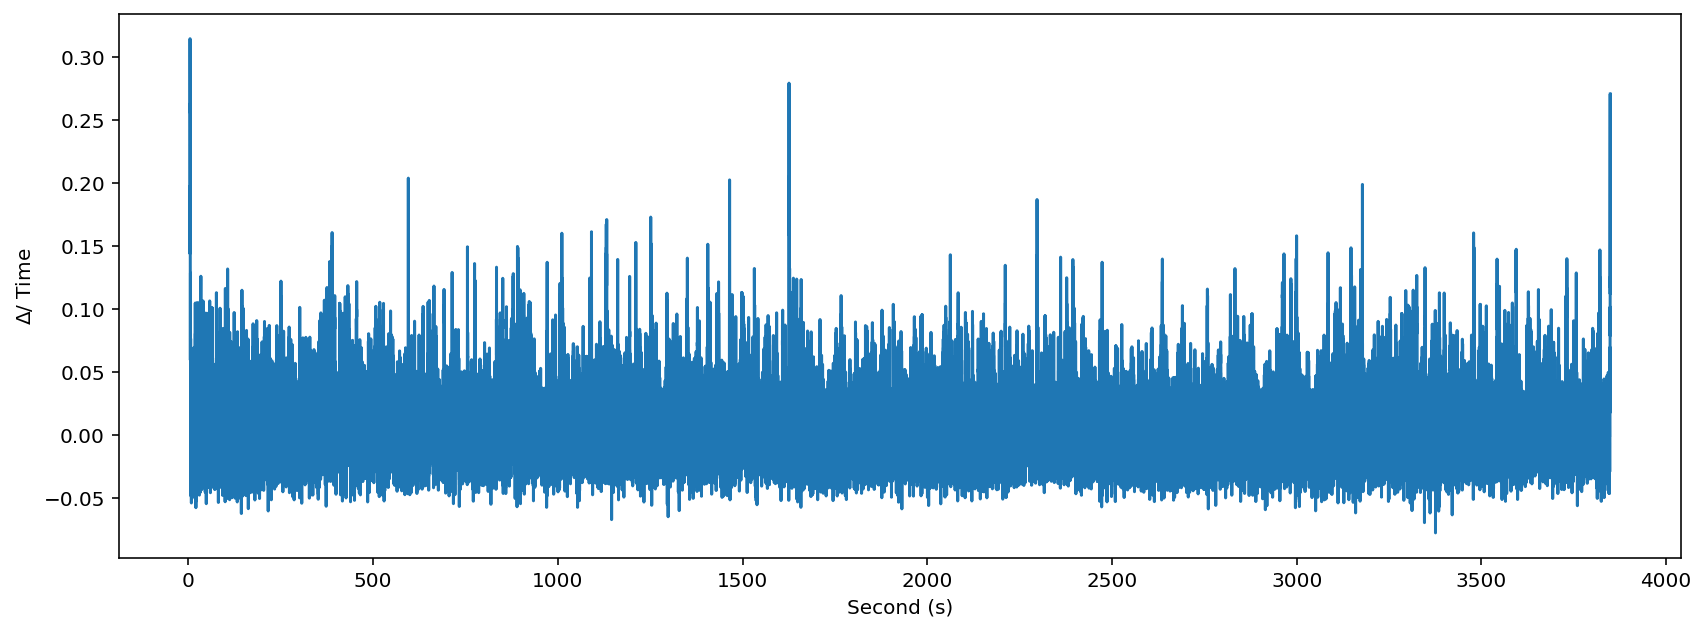

In [12]:
# Get all of the fluorescence traces (ts = timestamps; dff = deltaF/F)
ts, dff = data_set.get_dff_traces()

# Get the average change in fluorescence
dff_mean = dff.mean(axis=0)  #specifying the axis so get means across each neuron, not one value for all of time
print(dff_mean)

# Plot the sum of all of the fluorescence activity
plt.figure(figsize = (14,5))
plt.plot(ts, dff_mean)
plt.xlabel('Second (s)')
plt.ylabel('$\Delta/$ Time')


That's the imaged activity of all of the cells in our field of view, but does this activity correlate with the behavior of the animal? Specifically, let's look at the mouse's running speed.

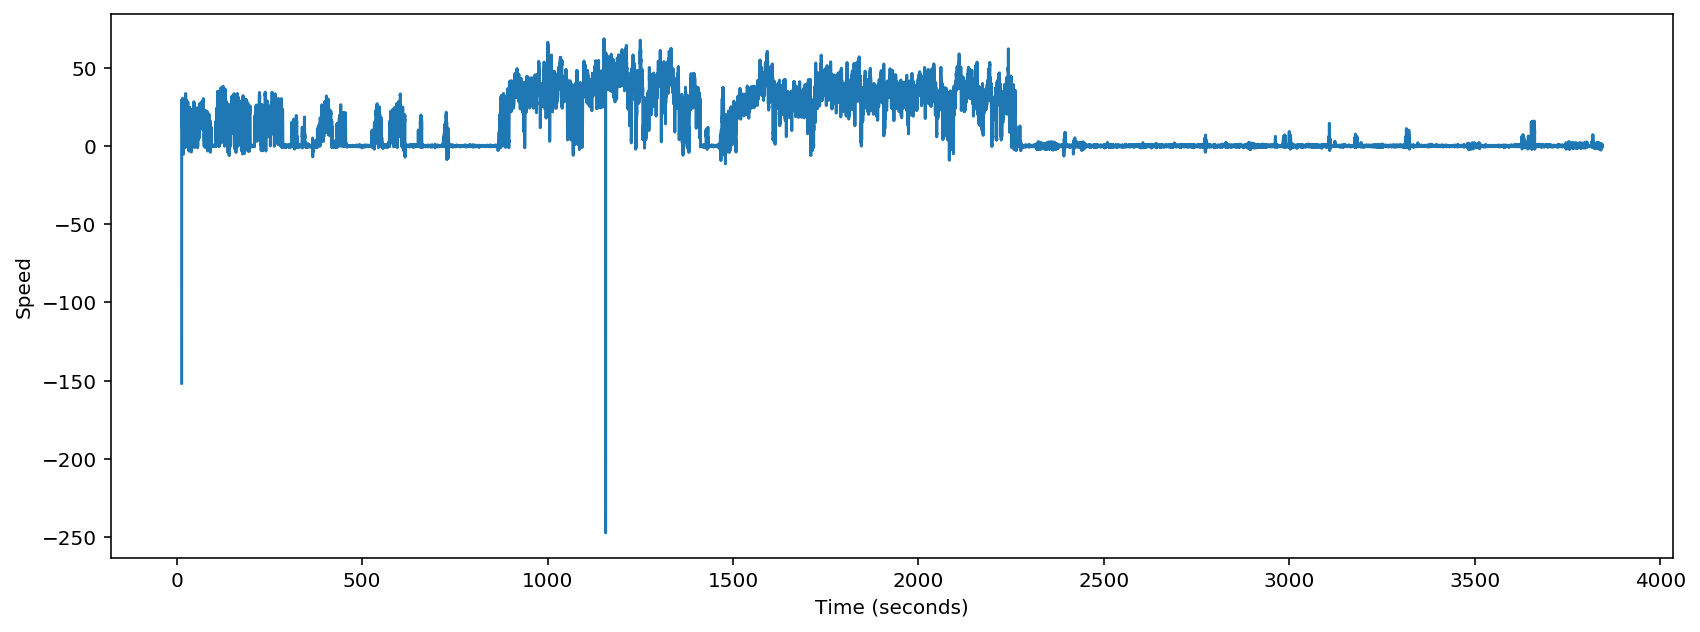

In [13]:
# Get the running speed from this dataset (dxcm = distance in cm; ts = timestamps)
dxcm, ts = data_set.get_running_speed()

# Plot it
plt.figure(figsize=(14,5))
plt.plot(ts,dxcm)
plt.xlabel('Time (seconds)')
plt.ylabel('Speed')
plt.show()

#pretty noisy, but can see periods of running and no running 

## Step 2. Clean up the running data and visualize.

Running activity is fairly coarse, so rather than try to predict the activity at 30Hz, let's bin the activity (summed across all neurons) into bins of 5 seconds.

In [14]:
bin_size = 5 #bin running and response activity for 5 seconds
bin_stamps = np.arange(0,ts.max(),bin_size)
num_bins = len(bin_stamps)

run_bin = np.empty(num_bins)
response_bin = np.empty(num_bins)

for i in range(num_bins):
    
    # Get the values within our time bin and take a mean
    run_bin[i] = dxcm[np.where((ts>i*bin_size)&(ts<((i+1)*bin_size)))].mean() 
    response_bin[i] = dff_mean[np.where((ts>i*bin_size)&(ts<((i+1)*bin_size)))].mean()

If we look at the `run_bin` we just created, we'll see there are some NaN values, since the running data is recorded for slightly less time than the 2P imaging. This might cause a problem later, so let's remove them. 

<div class="alert alert-success">

<b>Task</b>: Remove the NaNs from the running trace, and remove those same data points from the summed activity trace.

</div>

In [15]:
#cleaned the response bin first and then the run bin
#have to do the response bin first so that the datasets will still match 

response_bin = response_bin[~np.isnan(run_bin)]
run_bin = run_bin[~np.isnan(run_bin)]

In [17]:
run_bin

array([ 1.56177679e+01,  1.88223504e+01,  1.57240394e+01,  1.41560900e+01,
        1.11565521e+01,  1.05153389e+01,  1.23481465e+01,  1.17506446e+01,
        1.22647874e+01,  1.91952773e+01,  1.83217529e+01,  1.41570144e+01,
        1.05626624e+01,  1.25201454e+01,  9.12002048e+00,  5.45822062e+00,
        1.99828858e-03, -4.38713761e-04,  1.42243656e+01,  1.89923785e+01,
        3.01449019e+01,  2.11921184e+01,  1.88301699e+01,  2.17792258e+01,
        1.36243280e+01,  8.24349197e+00,  1.87293730e+01,  2.02376815e+01,
        1.25709982e+01,  2.29168704e+01,  1.91889848e+01,  1.74033999e+01,
        1.32407140e+01,  6.81701532e+00,  2.04243982e+01,  1.25340107e+01,
        1.00679578e+01,  4.55663117e-04,  5.35721792e-01,  1.74443429e+01,
        1.53834495e+01,  1.72867473e+01,  1.29050516e+01,  1.00780334e+01,
        1.96592721e+01,  1.45204987e+01,  1.39525219e+01,  1.26670333e+01,
        2.14638748e+01,  1.51534187e+01,  2.11460605e+01,  1.75349804e+01,
        1.29463858e+01,  

Plot our binned running and response traces together to see if there is, visually, any correlation.

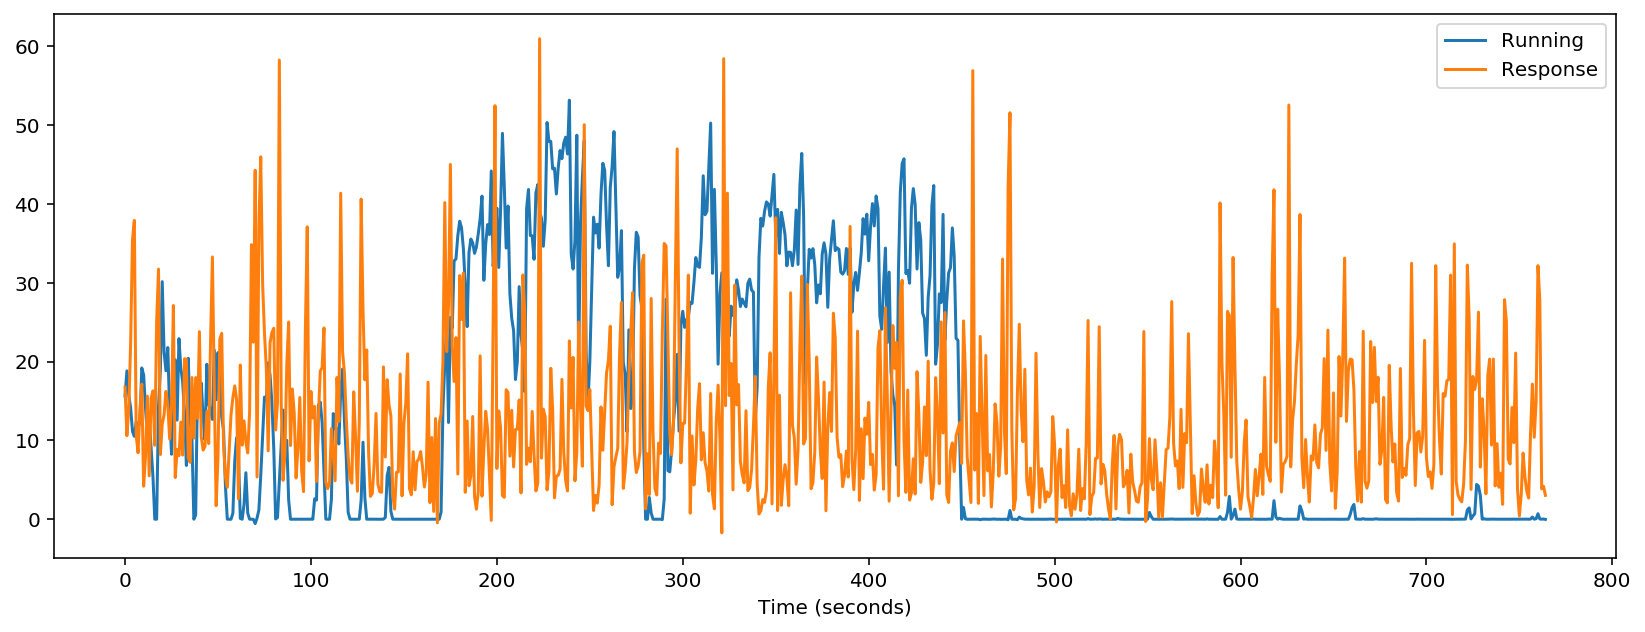

In [18]:
# Scale the response trace, so you can overlay them on the same scale (running data was higher)
response_bin_scaled = response_bin*1000

# Plot it
plt.figure(figsize=(14,5))
plt.plot(run_bin, label = 'Running')
plt.plot(response_bin_scaled, label = 'Response')
plt.legend()
plt.xlabel('Time (seconds)')
plt.show()

#now want to run a linear regression to see if there is a correlation between running and response

## Step 3: Predict fluorescence data from mouse's running speed

It's tough to tell visually, but maybe if we run a linear regression we'll be able to see if there is a relationship. 

When we run this linear regression (using least squares method) on our data, we need to decide which data to *train* the model on, and which data to *test* it on. Let's train it on samples 200 onward, since that contains a lot of variability. We'll then see if we can use the model to predict the first 200 samples.

**Side note**: We saw `linregress()` in the correlations notebook, which can work for these purposes. If you ever neet to run a regression with multivariate data, though, you'll need [lstsq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) in `scipy.linalg()`. See the commented lines of code below to see how this would work here. You'll notice they return similar, but slightly different, results.

In [19]:
# Subtract the mean from both response and running
response_bin -= response_bin.mean()
run_bin -= run_bin.mean()

# Run regression on training data & determine the coefficient 
#separating the data into a training and test data, first use the model on the training data 
coef, intercept, r_value, p_value, std_err = sp.stats.linregress(run_bin[200:], response_bin[200:])


# Alternative way to do this below, using a slightly different function
# from scipy.linalg import lstsq
# This ',None' business is because we have to append a column of to calculate intercept
# solution, residues, rank, singular_values = lstsq(run_bin[200:,None], response_bin[200:,None])
# coef = solution[0]

#slope of the linear regression
print(coef)

3.1057059205644996e-05


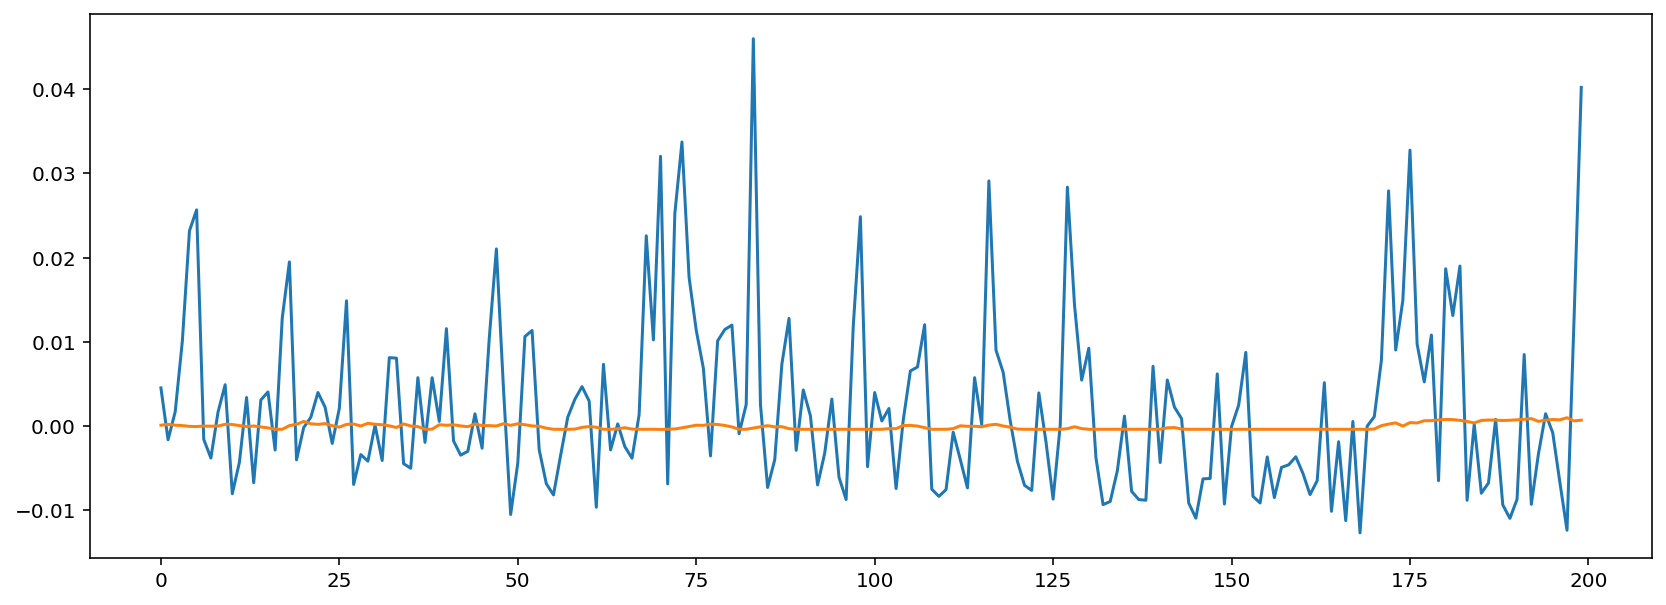

In [20]:
# Use the coefficient we generated to see if we can predict running activity
#use coeff to test the prediction on our test data
predict = coef*run_bin[:200]

# Plot the prediction
plt.figure(figsize=(14,5))
plt.plot(response_bin[:200])
plt.plot(predict)
plt.show()

#not a very good model, linear model is bad at predicting the data

To test how good this prediction is, we can use Pearson's *r*.

In [21]:
pearsons_r , pearsons_p = sp.stats.pearsonr(response_bin[:200], predict)
print("pearson's r: %f    pearson's p: %f" % (pearsons_r, pearsons_p))

pearson's r: 0.115785    pearson's p: 0.102537


## Step 4. Try this on other data!

Hmm, there isn't a clear linear relationship between running and the responses of all of the cells in this experiment. However, there definitely *are* cells that have a clear relationship!

Consider the following passage from [Yavorska & Weher (2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5040712/):

>  In visual cortex, running depolarizes both PNs and inhibitory cells. The resulting increase in both excitation and inhibition in PNs reduces membrane potential variance, and leads to more stimulus-evoked spikes without any increase in spontaneous activity (Polack et al., 2013). Whereas cholinergic input affects membrane potential fluctuations during quiescent periods, the effect of locomotion on membrane potential variance is mostly dependent on noradrenergic input. Interestingly, SOM neurons do not show decreased membrane potential variability during running, suggesting a differential influence of norepinephrine on SOM neurons and PNs (Polack et al., 2013). Different classes of inhibitory neurons show marked differences in how they are modulated by locomotion in the visual cortex. VIP neurons are depolarized throughout the entire running period, while PV cells only respond transiently at the beginning. SOM neurons are typically suppressed during running, and fire mostly at the end of the running period (Fu et al., 2014). These results suggest that the effect of locomotion is mediated by a disinhibitory circuit, in which VIP cells inhibit SOM cells and thereby increase the activity of neighboring PNs. 

<div class="alert alert-success">
    <b>Task</b>: Check to see if there are either <b>single cells</b> in the same experiment above or <b>an experiment in a different cell type</b> have strong correlations with running by editing the code above. Remember to choose a reasonable set of the data to train your model on.</div>

If you're curious, you could also try this on the Neuropixels dataset. It will work fairly similarly! The code below will get you started, see [here](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) for more documentation. Once you extract a session, you can use `session.running_speed()` or `session.get_pupil_data()`. See the [Neuropixels Cheat Sheet](https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/0f/5d/0f5d22c9-f8f6-428c-9f7a-2983631e72b4/neuropixels_cheat_sheet_nov_2019.pdf).

In [22]:
# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# We have all of this data on the datahub! This is where it lives.
manifest_path = '/datasets/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json' 

# Create the EcephysProjectCache object
cache = EcephysProjectCache.fixed(manifest=manifest_path)

# Get the sessions available in this dataset
sessions = cache.get_session_table()
print('Total number of sessions: ' + str(len(sessions)))
sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"
